### Variational Auto Encoder

* It's an autoencoder `X -> Z -> X_hat`
* Take probabilistic view: 
  + encoder: `P(Z|X)` - does inference. Learns what `z_i` should be for each `x_i`
  + initial values of `X ~ P(X|Z)`
  + decoder - generative network (mapping Z back to X). This is the **likelihood function** P(X|Z).
  + assume there is a local latent variable, `z_i` for each data point `x_i`.  Variable = parameter? 
    + we assume we have a probability distribution for P(Z|X).  All `z_i` share the same distribution? 
* Reparameterization trick
* Use family of distributions `Q(Z;B)` used to approximate the posterior

#### Some Key Ideas 

* Unlike a regular autoencoder we want the latent code to "learn" the probability distribution of the data.
* We'd like to be able to use our VAE as a generative model (to generate more data). Think `P(X,Z)`.
* You can use a neural network to parameterize a probability distribution for `P(Z|X)`.  Just learn this distribution during training



#### Sources

* Code from: https://github.com/hsaghir/VAE_intuitions/blob/master/VAE_MNIST_keras.ipynb
* Info from: https://hsaghir.github.io/data_science/denoising-vs-variational-autoencoder/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.objectives import binary_crossentropy
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


In [3]:
batch_size=100
digit_size=28
original_dim=784
intermediate_dim=256
latent_dim=2

nb_epochs=50
epsilon_std=1.0

### Sample the latent variable

We'll use the following function to turn the mean and log variance into a sample from a normal random variable. 

In [4]:
#why is this important?  What if we just use the mean in the encoder?
#in this case I guess we never calculate the mean or log variance that get used in the kl_loss function. 
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

### Encoder

In [5]:
#todo: make this into it's own model - include z as output. 
X=Input(batch_shape=(batch_size,digit_size*digit_size)) #need batch_shape here? 
h=Dense(intermediate_dim, activation='relu')(X)
z_mean=Dense(latent_dim)(h)  #rename z_mu
z_log_var=Dense(latent_dim)(h) #why log of variance?  why same input tensor? 

# z is effectively combining mean and variance layers through sampling func 
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#could also have multiple outputs here
encoder=Model(X, z_mean) #should we output z? 


In [6]:
z

<tf.Tensor 'lambda_1/add:0' shape=(100, 2) dtype=float32>

In [7]:
z_mean 

<tf.Tensor 'dense_2/BiasAdd:0' shape=(100, 2) dtype=float32>

### Decoder

In [8]:
#todo: make this into it's own model
d     = Dense(intermediate_dim, activation='relu')(z) #if decoder takes z then I would think we'd produce z not z_mean from the encoder.  could return both. 
X_bar = Dense(original_dim,activation='sigmoid')(d)


In [9]:
#trying to make this work with a Input.  copying from previous cell.
inp     = Input(shape=(latent_dim,))
d       = Dense(intermediate_dim, activation='relu')(inp)
X_bar   = Dense(original_dim,activation='sigmoid')(d)
decoder = Model(inp, X_bar)

### VAE Loss function

In [10]:
# consider using this - https://keras.io/losses/#kullback_leibler_divergence

#really strange.  Relies on a bunch of globals: z_log_var and z_mean
def vae_loss(x, x_bar):
    reconst_loss = original_dim * binary_crossentropy(x, x_bar) #why binary_crossentropy? 
    kl_loss = -0.5*K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

#z_mean is the mean of 100, 2 dimensional z values.  Is the reparameterization trick happening here?

### End to End Model

In [11]:
out_e2e = decoder(z)
# build and compile model
vae=Model(X , out_e2e)
vae.compile(optimizer='adam', loss=vae_loss)

### Get The Data

In [12]:
# load MNIST data for training
(x_train, y_train),(x_test, y_test)=mnist.load_data()

# normalize input and make them float32 to run on GPU
x_train=x_train.astype('float32')/ 255.
x_test=x_test.astype('float32')/255.

# convert 28x28 images into 784-vectors
x_train=x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Train the Model

In [13]:
vae.fit(x_train,x_train, shuffle=True, epochs=nb_epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s - loss: 199.0898 - val_loss: 172.6288
Epoch 2/50
60000/60000 [==============================] - 5s - loss: 170.7371 - val_loss: 168.8856
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 167.3397 - val_loss: 165.7579
Epoch 4/50
60000/60000 [==============================] - 5s - loss: 164.9010 - val_loss: 163.8021
Epoch 5/50
60000/60000 [==============================] - 5s - loss: 163.2128 - val_loss: 162.5162
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 161.9880 - val_loss: 161.6303
Epoch 7/50
60000/60000 [==============================] - 5s - loss: 160.8896 - val_loss: 160.6323
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 159.9499 - val_loss: 160.0545
Epoch 9/50
60000/60000 [==============================] - 5s - loss: 159.1216 - val_loss: 158.9132
Epoch 10/50
60000/60000 [==============================] - 

In [15]:
z_test = encoder.predict(x_test,batch_size=batch_size)  #assume these weights already trained.

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(z_test[:,0], z_test[:,1], c=y_test)  #note use of labels for 'c'
plt.colorbar()
plt.show()

In [17]:
z_sample=np.array([np.random.normal(0, 1, 2)])
print(z_sample)

[[ 0.2145308   1.71062537]]


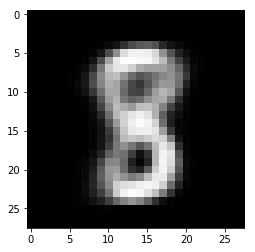

In [19]:
x_hat=decoder.predict(z_sample)
sampled_im=x_hat[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

In [36]:
z_sample=np.array([np.random.normal(0, 1, 2)])
print(z_sample)
x_hat=decoder.predict(z_sample)
sampled_im=x_hat[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

[[-0.32637813  0.56289245]]


In [37]:
z_sample=np.array([np.random.normal(0, 1, 2)])
print(z_sample)
x_hat=decoder.predict(z_sample)
sampled_im=x_hat[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

[[-0.7609616   0.64861649]]


In [35]:
# what does 0,0 look like?
zz = np.array([np.zeros(2)])
print((0,0))
x_hat=decoder.predict(zz)
sampled_im=x_hat[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

In [ ]:
#next steps

# how do you generate new samples of X?  Will this really get the distribution of data right? In other words, 
# if the training data has the same proportion of examples from each digit would this method as well? 

#build a function that finds the point in the training or test data with the closest label.  
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html

# encode all x_test or x_train.
# generate a bunch of samples with numpy
# run a pairwise dist calc between these things.  You'll get a matrix of distances back
# grab the shortest distance value.  Output the prediction.
# look at the sample.
# bucketize all predictions
# look at distribution of test cases vs distribution of samples produced.  Is it roughly the same?  Should it be?

# look up the kl_divergence or kl_loss fuction in keras.  what does the implementation look like?  Can you learn from it?

# https://blog.keras.io/building-autoencoders-in-keras.html

# on second thought...not sure if it's fair to generate samples with numpy random normal.

In [30]:
x_test.shape

(10000, 784)

### VAE in Pyro and PyTorch

http://pyro.ai/examples/vae.html

In [5]:
import torch
from torch import nn
import torchvision.datasets as dset
import torchvision.transforms as transforms

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784) #Linear is like Dense.
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()  #so strange that we have to do this.  I guess it's like an activation layer (would it be reused?)
        
    #decoder
    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        mu_img = (self.sigmoid(self.fc21(hidden))+fudge) * (1-2*fudge) #fudge helps with numerical instability of sigmoid but where is it defined?
        return mu_img